# Data Mining

——文本分类：寻找24本书的相关性并将相似的聚类

## 1. 编写运算所需类和函数

In [133]:
%matplotlib inline
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

from scipy.cluster.hierarchy import ward, dendrogram

In [13]:
# filter stopwords
stopwords = stopwords.words('english')
en_words = set(words.words())
stemmer = SnowballStemmer('english')

In [14]:
# 按照文件读取顺序排列的书籍名称
titles = ['THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI',
          'THE HISTORIES CAIUS COBNELIUS TACITUS',
          'THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I',
          'THE HISTORY OF TACITUS. BOOK I. VOL. V',
          'THE FIRST AND THIRTY-THIRD BOOKS OF PLINY\'S NATURAL HISTORY',
          'THE HISTORY OF THE ROMAN EMPIRE. VOL. V',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II',
          'THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II',
          'TITUS LIVIUS\' ROMAN',
          'THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL. I',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV',
          'DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II',
          'THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III',
          'LIVY. VOL. III',
          'LIVY. VOL. V',
          'THE HISTORICAL ANNALS OF CORNELIUS TACITUS. VOL. I',
          'THE HISTORY OF THE PELOPONNESIAN WAR. VOL. I',
          'THE LEARNED AND AUTHENTIC JEWISH HISTORIAN,  AND CELEBRATED WARRIOR. VOL. IV',
          'THE DESCRIPTION OF GREECE',
          'THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III',
          'TTHE HISTORY OF ROME. VOL. III',
          'HE HISTORY OF TACITUS. BOOK I. VOL. IV',
          'THE FLAVIUS JOSEPHU',
          ]

In [15]:
def tokenize_and_filter_punc(raw_text):
    tokens = nltk.wordpunct_tokenize(raw_text)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]

    return words

In [16]:
class BookObject(object):
    """
    每一本书籍建立一个类的对象
    """
    def __init__(self, title, contents, raw_texts=''):
        self.__title = title
        self.__contents = contents
        self.__raw_texts = raw_texts

    @property
    def title(self):
        return self.__title

    @property
    def raw_texts(self):
        return self.__raw_texts

    @property
    def contents(self):
        return self.__contents.keys()

In [134]:
class TextClassification(object):
    """
    添加方法：
    添加一本书
    加载原始文本
    特征工程：计算文本单词数量，统计高频名词
    tf-idf方法
    k-means方法
    hierachical方法
    """
    def __init__(self):
        self.__books = []
        self.__no_of_features = 0
        self.__total_vocabularies = []
        self.__tf_idf_matrix = None
        self.__dist_matrix = None

    def add_a_book(self, book):
        self.__books.append(book)

    # 特征工程
    # 打印单词数量
    def print_word_count(self):
        words_count = {}
        for book in self.__books:
            text_arr = book.raw_texts.strip().split()
            count = 0
            for w in text_arr:
                if len(w) > 0:
                    count += 1

            words_count[book.title] = count

        print('The word counts of each book is:\n')
        for key, value in words_count.items():
            print(key, ':', value)

    # 打印tokenize之后的单词数量
    def print_word_count_after_tokenization(self):
        words_count = {}
        for book in self.__books:
            text = book.raw_texts.strip()
            res = tokenize_and_filter_punc(text)
            words_count[book.title] = len(res)

        print('The word counts of each book after tokrnize is:\n')
        for key, value in words_count.items():
            print(key, ':', value)
    
    # 输出每本书使用频率前20名的单词
    def highfreq_noun(self):
        print('High frequency noun in each book:\n')
        for book in self.__books:
            text = book.raw_texts
            tokens = tokenize_and_filter_punc(text)
            freq_dist = FreqDist(tokens)
            tagged = nltk.pos_tag(tokens)
            minfo = dict(freq_dist)
            info = list(set([k.lower() for k,v in tagged if v == 'NN']))
            kinfo = [(k,minfo.get(k)) for k in info]
            kinfo.sort(key=lambda k:k[1],reverse=True)
            kinfo = [w for w in kinfo if len(w[0]) > 3]
            output1 = ",".join([m[0] for m in kinfo[:20]])
            print('《',book.title[:-4], '》:\n', output1)
            output2 = " ".join([m[0] for m in kinfo[:20]])
            this_wordcloud = WordCloud().generate(output2)
            plt.imshow(this_wordcloud)
            plt.axis('off')
            plt.show()
            
            

    # TF-IDF计算词频
    def tf_idf(self):
        tfidf_matrix = None
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9,
                                           max_features=200000, 
                                           min_df=0.01, 
                                           stop_words='english',
                                           use_idf=True,  
                                           tokenizer=tokenize_and_filter_punc, 
                                           ngram_range=(1, 1))
        books = []
        for book in self.__books:
            books.append(book.raw_texts)

        tfidf_matrix = tfidf_vectorizer.fit_transform(books)

        self.__tf_idf_matrix = tfidf_matrix
        print(self.__tf_idf_matrix.shape)

        self.__dist_matrix = 1 - cosine_similarity(self.__tf_idf_matrix)

    # K-means算法
    def k_mean_clustering(self, n_clusters=5):
        num_clusters = n_clusters

        km = KMeans(n_clusters=num_clusters)
        km.fit(self.__tf_idf_matrix)
        clusters = km.labels_.tolist()
#         print(clusters)

        synopses = []
        for book in self.__books:
            synopses.append(book.raw_texts)

        books = {'title': titles, 'synopsis': synopses, 'cluster': clusters}

        frame = pd.DataFrame(books, index = [clusters] , columns = ['title', 'cluster'])
        print(frame['cluster'].value_counts())
        #grouped = frame['title'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

        #print grouped.mean() #average rank (1 to 100) per cluster

        # convert two components as we're plotting points in a two-dimensional plane
        # "precomputed" because we provide a distance matrix
        # we will also specify `random_state` so the plot is reproducible.
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

        pos = mds.fit_transform(self.__dist_matrix)  # shape (n_components, n_samples)
        xs, ys = pos[:, 0], pos[:, 1]
#         print(xs)
#         print(ys)

        #set up colors per clusters using a dict
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

        #set up cluster names using a dict
        cluster_names = {0: 'Group 1',
                         1: 'Group 2',
                         2: 'Group 3',
                         3: 'Group 4',
                         4: 'Group 5'}

        #create data frame that has the result of the MDS plus the cluster numbers and titles
        df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))

        #group by cluster
        groups = df.groupby('label')

        # set up plot
        fig, ax = plt.subplots(figsize=(20, 14)) # set size
        ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

        #iterate through groups to layer the plot
        #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                    label=cluster_names[name], color=cluster_colors[name],
                    mec='none')
            ax.set_aspect('auto')
            ax.tick_params(\
                axis= 'x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelbottom='off')
            ax.tick_params(\
                axis= 'y',         # changes apply to the y-axis
                which='both',      # both major and minor ticks are affected
                left='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelleft='off')

        ax.legend(numpoints=1)  #show legend with only 1 point

        #add label in x,y position with the label as the film title
        for i in range(len(df)):
            ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)

        plt.show() #show the plot

    # 层级聚类
    def hierachical_clustering(self):
        linkage_matrix = ward(self.__dist_matrix) #define the linkage_matrix using ward clustering pre-computed distances

        fig, ax = plt.subplots(figsize=(15, 9)) # set size
        ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

        plt.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        fig.set_tight_layout(True) #show plot with tight layout
        plt.show()

    # 加载原始文本并运行
    def load_raw_text(self):
        rootdir = '/Users/suhang/Documents/GitHub/COMP6237-Data-Mining/cw2-understanding-data/raw_text'
        files = os.listdir(rootdir)
        for file in files:
            if file != '.DS_Store':
                file_path = os.path.join(rootdir, file)
                if os.path.isfile(file_path):
                    with open(file_path) as f:
                        raw_texts = f.read()

                        book = BookObject(file, {}, raw_texts=raw_texts)
                        self.add_a_book(book)

## 2. 创建对象并调用函数，输出结果

In [135]:
test = TextClassification()

In [136]:
test.load_raw_text()

### 2.1 初步探索

#### 2.1.1 统计每本书使用率前20名的名词

High frequency noun in each book:

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI 》:
 torn,roman,empire,hundred,thousand,mahomet,chap,name,emperor,hist,city,greeks,life,arabs,religion,death,church,caliph,reign,rome


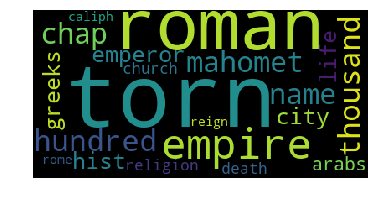

《 THE HISTORIES CAIUS COBNELIUS TACITUS 》:
 note,quam,quod,vitellius,tacitus,subj,galba,inter,neque,otho,quae,apud,essay,word,hist,sense,militum,exercitus,ejus,suet


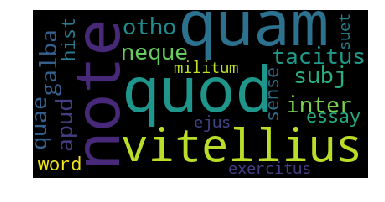

《 THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV 》:
 upon,jews,city,very,josephus,while,temple,before,time,king,place,wall,titus,come,jerusalem,vespasian,country,together,away,army


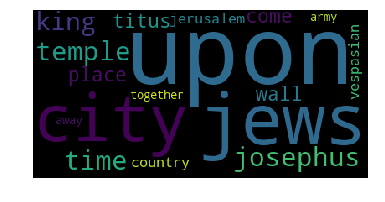

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I 》:
 roman,empire,emperor,rome,hist,senate,death,decline,fall,public,well,power,time,life,general,august,ancient,army,reign,part


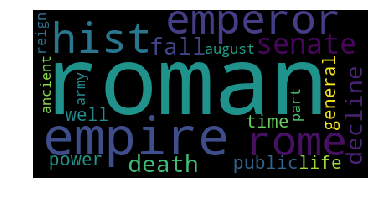

《 THE HISTORY OF TACITUS. BOOK I. VOL. V 》:
 book,otho,vitellius,history,time,tacitus,galba,army,section,rome,nero,legion,emperor,public,city,whole,vespasian,enemy,camp,prince


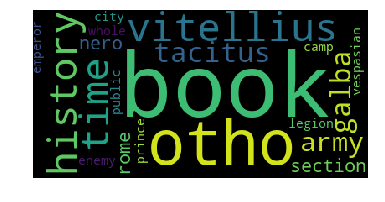

《 THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY 》:
 gold,silver,kind,time,very,copper,account,weight,order,lead,while,substance,word,note,name,book,part,minium,term,water


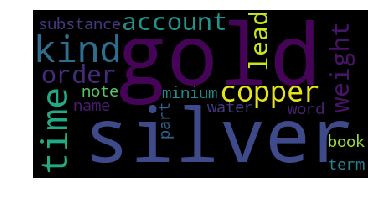

《 THE HISTORY OF THE ROMAN EMPIRE. VOL. V 》:
 roman,chap,empire,justinian,thousand,emperor,hundred,first,fall,decline,belisarius,rome,italy,king,name,death,city,reign,general,public


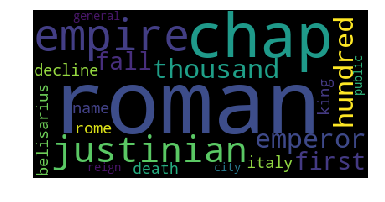

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II 》:
 julian,roman,empire,chap,emperor,decline,fall,public,death,constantine,constantius,troops,theodosius,army,city,general,east,military,reign,imperial


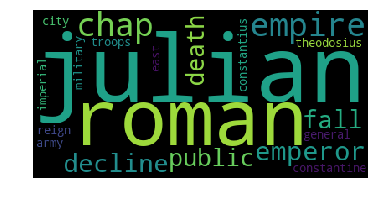

《 THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II 》:
 upon,time,whole,enemy,though,present,fleet,farther,therefore,city,before,hundred,state,sicily,make,force,land,athenian,army,sent


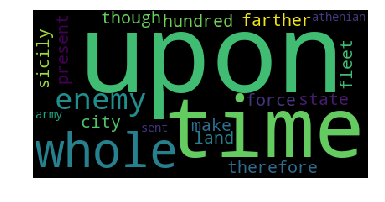

《 TITUS LIVIUS' ROMAN 》:
 have,roman,chap,city,time,upon,rome,enemy,senate,consuls,army,before,titus,history,consul,book,camp,country,livius,volsci


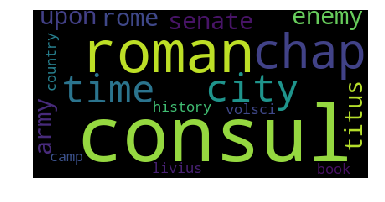

《 THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I 》:
 have,city,time,fuch,enemy,rome,fhould,againft,fenate,thefe,confuls,thofe,fame,roman,firft,conful,mould,book,camp,year


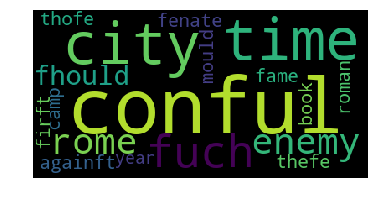

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV 》:
 roman,chap,empire,emperor,fall,justinian,decline,first,thousand,belisarius,rome,italy,reign,constantinople,city,death,king,name,palace,general


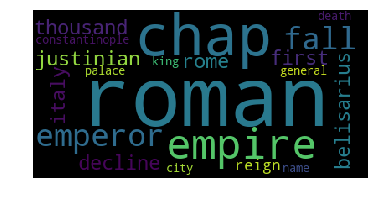

《 DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II 》:
 name,town,city,ancient,place,river,time,part,strab,about,roman,coast,temple,ptol,though,first,pliny,country,plin,site


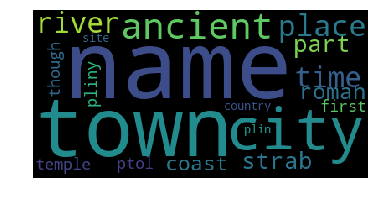

《 THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III 》:
 upon,jews,have,king,herod,about,sent,city,very,before,time,while,come,chap,caesar,agrippa,country,thou,account,together


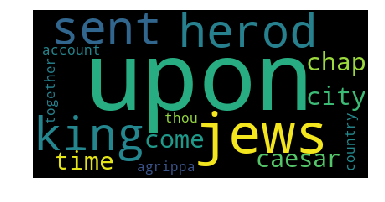

《 LIVY. VOL. III 》:
 have,enemy,rome,consul,time,roman,army,made,consuls,camp,book,senate,while,history,troops,city,either,battle,thousand,sent


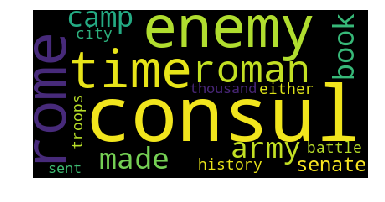

《 LIVY. VOL. V 》:
 time,rome,enemy,city,roman,scipio,king,sent,senate,army,consul,while,book,thousand,history,troops,camp,general,hannibal,livy


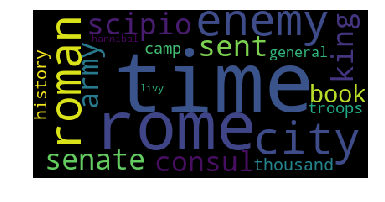

《 THE HISTORICAL ANNALS OF CORNELIUS TACITUS. VOL. I 》:
 tiberius,time,germanicus,senate,rome,augustus,roman,prince,public,army,tacitus,piso,emperor,drusus,general,country,nothing,before,name,father


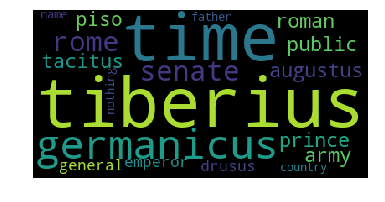

《 THE HISTORY OF THE PELOPONNESIAN WAR. VOL. I 》:
 upon,such,time,city,hath,very,year,though,over,whole,athenian,public,present,greece,peloponnesian,power,place,part,thucydides,state


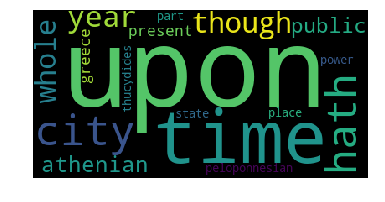

《 THE LEARNED AND AUTHENTIC JEWISH HISTORIAN,  AND CELEBRATED WARRIOR. VOL. IV 》:
 king,jews,upon,herod,about,very,city,sent,temple,chap,time,country,army,come,jerusalem,while,book,away,hyrcanus,account


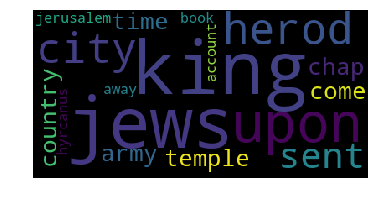

《 THE DESCRIPTION OF GREECE 》:
 city,statue,page,place,temple,apollo,homer,river,jupiter,time,account,daughter,part,olympic,therefore,fame,hence,greece,picture,statuary


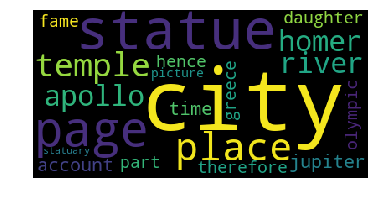

《 THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III 》:
 torn,roman,first,hundred,thousand,empire,emperor,justinian,name,city,rome,death,hist,constantinople,mahomet,reign,life,fall,general,italy


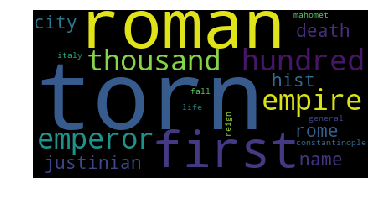

《 THE HISTORY OF ROME. VOL. III 》:
 roman,even,sulla,rome,senate,time,state,such,army,king,government,italy,very,gracchus,book,general,chap,before,italian,gaius


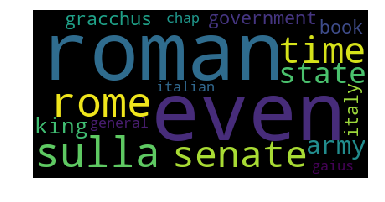

《 THE HISTORY OF TACITUS. BOOK I. VOL. IV 》:
 nero,book,life,time,rome,emperor,death,daughter,tacitus,wife,public,roman,table,augustus,prince,claudius,section,suet,galba,city


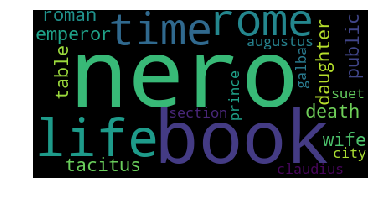

《 THE FLAVIUS JOSEPHU 》:
 king,upon,jews,about,very,city,time,before,sent,over,come,because,josephus,temple,army,david,country,place,thou,while


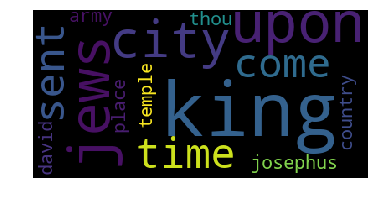

In [137]:
test.highfreq_noun()

#### 2.1.2 输出切分词前每本书的单词数量统计结果

In [63]:
test.print_word_count()

The word counts of each book is:

THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI.txt : 213422
THE HISTORIES CAIUS COBNELIUS TACITUS.txt : 169627
THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV.txt : 233950
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I.txt : 272089
THE HISTORY OF TACITUS. BOOK I. VOL. V.txt : 74210
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY.txt : 30706
THE HISTORY OF THE ROMAN EMPIRE. VOL. V.txt : 205502
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II.txt : 166971
THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II.txt : 136976
TITUS LIVIUS' ROMAN.txt : 175865
THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I.txt : 192044
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV.txt : 175260
DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II.txt : 1659053
THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III.txt : 230261
LIVY. VOL. III.txt : 115565
LIVY. VOL. V.txt : 148879
THE HISTORICAL

#### 2.1.3 输出切分词后每本书的单词数量统计结果

In [64]:
test.print_word_count_after_tokenization()

The word counts of each book after tokrnize is:

THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI.txt : 209590
THE HISTORIES CAIUS COBNELIUS TACITUS.txt : 156262
THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV.txt : 228474
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL, I.txt : 264682
THE HISTORY OF TACITUS. BOOK I. VOL. V.txt : 72599
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY.txt : 29786
THE HISTORY OF THE ROMAN EMPIRE. VOL. V.txt : 200783
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II.txt : 164368
THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II.txt : 134429
TITUS LIVIUS' ROMAN.txt : 174997
THE HISTORY OF ROME,  BY TITUS LIVIUS. VOL, I.txt : 191334
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV.txt : 172728
DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II.txt : 1603581
THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III.txt : 225245
LIVY. VOL. III.txt : 114300
LIVY. VOL. V.txt : 148669

#### 2.2 文本向量化

In [65]:
#TF-IDF
test.tf_idf()

(24, 200000)


### 3.根据用词相似度使用不同算法进行文本分类

#### 3.1 使用K-means算法进行分类

0    8
2    5
3    4
1    4
4    3
Name: cluster, dtype: int64


/Users/suhang/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


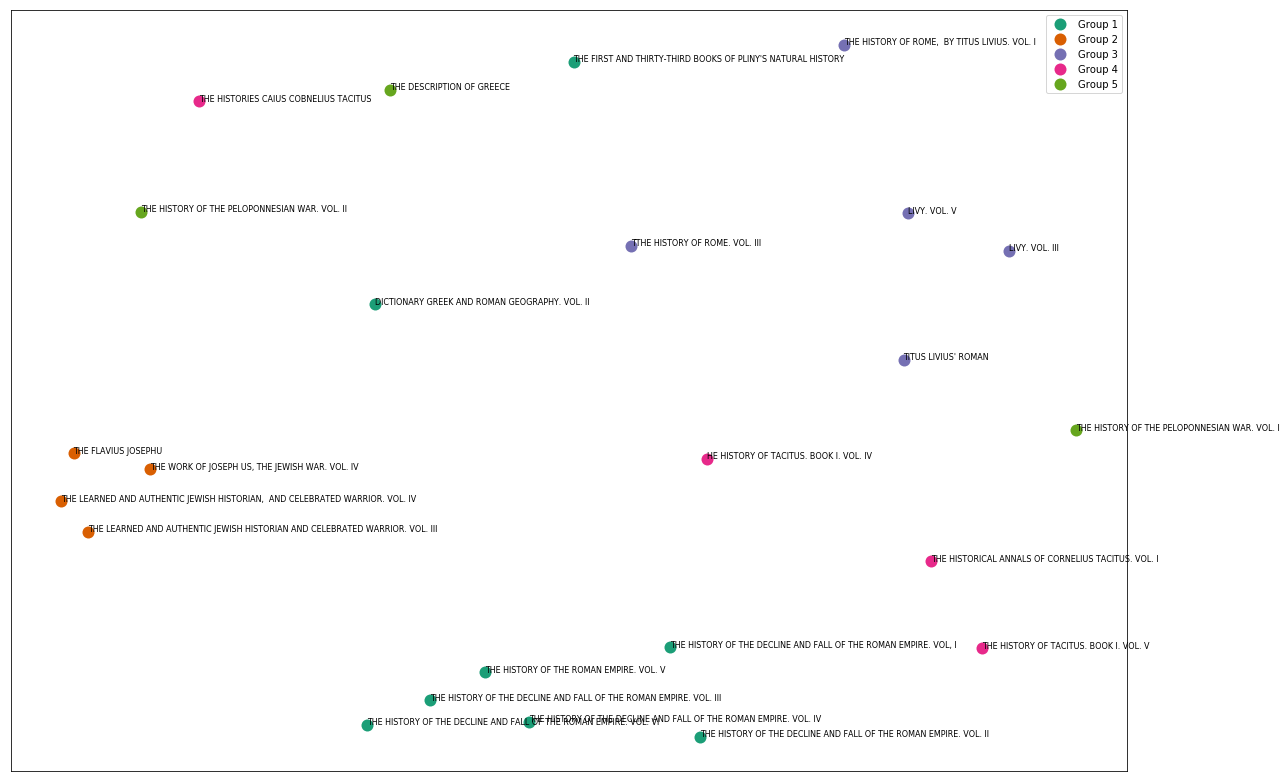

In [66]:
# K-means 聚类
test.k_mean_clustering()

### Classification results

#### K-means Result:



|1. Group 1:|
|----|
    |- **THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY**; |
    |- DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II; |
    |- **THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI**; |
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. I; |
    |- **THE HISTORY OF THE ROMAN EMPIRE. VOL. V**; |
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II; |
    |- **THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV**; |
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III|
    
|2. Group 2:|
|---|
    |- **THE FLAVIUS JOSEPHU**;| 
    |- THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV; |
    |- **THE LEARNED AND AUTHENTIC JEWISH HISTORIAN AND CELEBRATED WARRIOR. VOL. III**; |
    |- THE LEARNED AND AUTHENTIC JEWISH HISTORIAN,AND CELEBRATED WARRIOR. VOL. IV;|

|3. Group 3:|
|----|
    |- **THE HISTORY OF ROME,BY TITUS LIVIUS. VOL. I**; |
    |- LIVY. VOL. III;| 
    |- **LIVY. VOL. V**; |
    |- THE HISTORY OF ROME. VOL. III*; **TITUS LIVIUS' ROMAN;|
    
|4. Group 4:|
|----|
    |- **THE HISTORY OF TACITUS. BOOK I. VOL. IV**; |
    |- THE HISTORICAL ANNALS OF CORNELIUS TACITUS. VOL. I; |
    |- **THE HISTORY OF TACITUS. BOOK I. VOL. V**; |
    |- THE HISTORIES CAIUS COBNELIUS TACITUS|
    
|5. Group 5:|
|----|
    |- THE DESCRIPTION OF GREECE**; |
    |- THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II;|

#### 3.2 使用层级聚类算法进行分类

/Users/suhang/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


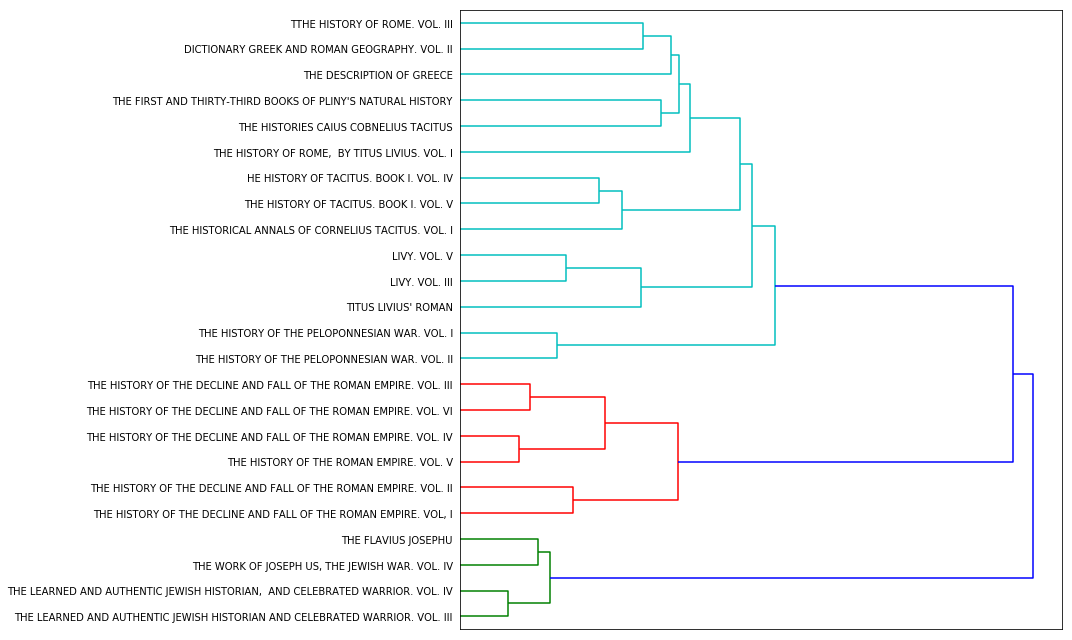

In [67]:
# 层级聚类
test.hierachical_clustering()

#### Hierachical Clustering Results:
|1. Group 1:|
|----|
    |- THE HISTORY OF ROME. VOL. III;|
    |- DICTIONARY GREEK AND ROMAN GEOGRAPHY. VOL. II;|
    |- THE DESCRIPTION OF GREECE;|
    |- THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY;|
    |- THE HISTORIES CAIUS COBNELIUS TACITUS;|
    |- THE HISTORY OF ROME, BY TITUS LIVIUS. VOL. I;|
    |- THE HISTORY OF TACITUS. BOOK I. VOL. IV;|
    |- THE HISTORY OF TACTIUS. BOOK I. VOL. V;|
    |- THE HISTORICAL ANNALS OF CORNELIUS TACTITUS. VOL. I;|
    |- LIVY. VOL. V;|
    |- LIVY. VOL. III;|
    |- TITUS LIVIUS' ROMAN;|
    |- THE HISTORY OF THE PELOPONNESIAN WAR. VOL. I;|
    |- THE HISTORY OF THE PELOPONNESIAN WAR. VOL. II;|

|2. Group 2:|
|----|
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. I;|
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. II;|
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. III;|
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. IV;|
    |- THE HISTORY OF THE ROMAN EMPIRE. VOL. V;|
    |- THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE. VOL. VI;|

|3. Group 3:|
|----|
    |- THE FLAVIUS JOSEPHU;|
    |- THE WORK OF JOSEPH US, THE JEWISH WAR. VOL. IV;|
    |- THE LEARNED AND AUTHENTIC JEWISH HISTORIAN, AND CELEBRATED WARRIOR. VOL. III;|
    |- THE LEARNED AND AUTHENTIC JEWISH HISTORIAN, AND CELEBRATED WARRIOR. VOL. IV;|

### 4. Brief conclusion：

层级聚类的分类结果比5个聚类的k-means结果要好。

在层级聚类中：
- 第一类都是关于古希腊古罗马历史文化的书籍
- 第二类全部是罗马帝国兴衰历史的1-6卷
- 第三类均为关于犹太文化历史信息的书籍